# Why Does Unsupervised Pre-training Help Deep Learning?

В работе я не смог воспризвести требуемый рисунок из-за большой вычислительной сложности. Однако я смог реализовать процесс предварительного обучения однослойной SDAE

## Theory

В статье получен результат, согласно которому предварительное обучение модели влияло на качество предсказаний даже по мере значительного роста обучающей выборки.

В статье это объясняют невыпуклостью целевой функции. Модель, обученная на классификацию мниста не может распознавать цифры также хорошо, как модель, предварительно обученная на генерацию этих цифр. 

В лабораторной работе предлагалось повторить этот эксперимент для модели SDAE

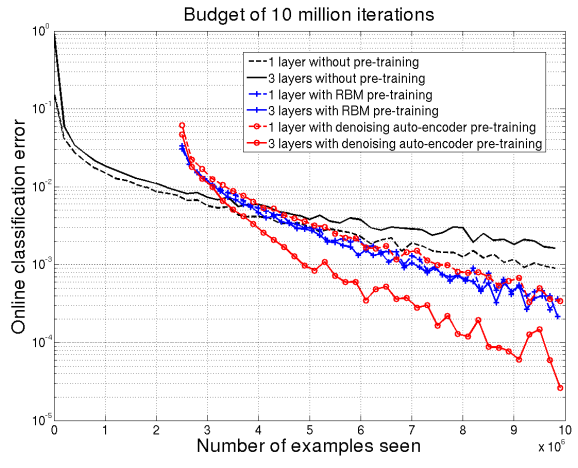

## Pre-train Experiment

Эксперимент проводился на бесконечном мнисте. В связи с генерацией изображений возникали проблемы по системной памяти RAM. В результате 11 миллионов сэмплов из эксперимента были сгенерированы порциями и сохранены ввиде архива на диске. Процесс сохранения можно посмотреть в разделе `load_data`

### Infinite MNIST

Official [site](https://leon.bottou.org/projects/infimnist) provides library functionality in C language. We will use python binding from [here](https://github.com/albietz/infimnist_py)

#### Download the data

In [1]:
!wget https://leon.bottou.org/_media/projects/infimnist.tar.gz

--2022-12-13 18:26:21--  https://leon.bottou.org/_media/projects/infimnist.tar.gz
Resolving leon.bottou.org (leon.bottou.org)... 216.165.22.6
Connecting to leon.bottou.org (leon.bottou.org)|216.165.22.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 366483033 (350M) [application/octet-stream]
Saving to: ‘infimnist.tar.gz’

infimnist.tar.gz    100%[===================>] 349.50M  56.3MB/s    in 5.7s    

2022-12-13 18:26:27 (61.2 MB/s) - ‘infimnist.tar.gz’ saved [366483033/366483033]



In [2]:
!sudo tar -xvf infimnist.tar.gz

infimnist/
infimnist/.gitattributes
infimnist/.gitignore
infimnist/COPYING
infimnist/Makefile
infimnist/NMakefile
infimnist/README
infimnist/data/
infimnist/data/fields_float_1522x28x28.bin
infimnist/data/t10k-images-idx3-ubyte
infimnist/data/t10k-labels-idx1-ubyte
infimnist/data/tangVec_float_60000x28x28.bin
infimnist/data/train-images-idx3-ubyte
infimnist/data/train-labels-idx1-ubyte
infimnist/infimnist.c
infimnist/infimnist.h
infimnist/main.c


#### Clone and setup python binding

In [3]:
!git clone https://github.com/albietz/infimnist_py.git

Cloning into 'infimnist_py'...
remote: Enumerating objects: 37, done.
remote: Total 37 (delta 0), reused 0 (delta 0), pack-reused 37
Unpacking objects: 100% (37/37), done.


In [4]:
!mv infimnist/data/ infimnist_py/data/

In [5]:
!rm -r infimnist/
!rm infimnist.tar.gz

In [1]:
%cd infimnist_py/

/content/infimnist_py


In [2]:
!python setup.py build_ext -if

running build_ext
building '_infimnist' extension
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.8 -c _infimnist.c -o build/temp.linux-x86_64-3.8/_infimnist.o
In file included from /usr/include/numpy/ndarraytypes.h:1809:0,
                 from /usr/include/numpy/ndarrayobject.h:18,
                 from /usr/include/numpy/arrayobject.h:4,
                 from _infimnist.c:585:
/usr/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: #warning "Using deprecated NumPy API, disable it by " "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
 #warning "Using deprecated NumPy API, disable it by " \
  ^~~~~~~
_infimnist.c: In function ‘__Pyx_modinit_type_init_code’:
_infimnist.c:19903:3: warning: ‘tp_print’ is deprecated [-Wdeprecated-dec

The following code generate first test example, firts train example and first train transformation

Text(0.5, 1.0, 'label: 7')

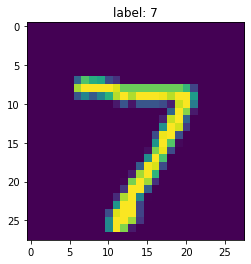

In [3]:
import _infimnist as infimnist
import numpy as np

mnist = infimnist.InfimnistGenerator()
indexes = np.array([0, 10000, 70000], dtype=np.int64)
digits, labels = mnist.gen(indexes)

# example of preprocessing from [0, 255] to [0., 1.]
X = digits.astype(np.float32).reshape(indexes.shape[0], 28, 28)
X = X / 255

import matplotlib.pyplot as plt
plt.imshow(X[0])
plt.title('label: {}'.format(labels[0]))

In [4]:
%cd ../

/content


first train example

Text(0.5, 1.0, 'label: 5')

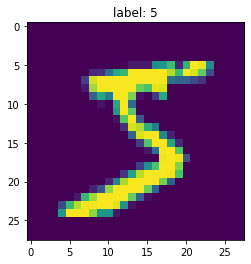

In [5]:
plt.imshow(X[1])
plt.title('label: {}'.format(labels[1]))

first train transformation

Text(0.5, 1.0, 'label: 5')

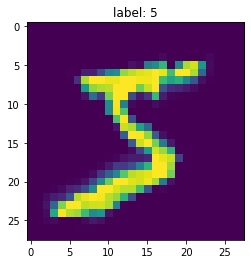

In [6]:
plt.imshow(X[2])
plt.title('label: {}'.format(labels[2]))

### Basic Imports

Поскольку первая лаба была написана на чистом джаксе, здесь мы используем библиотеку `Flax`, реализующую стандартные методы инициализации моделей, а также библиотеку `optax` для оптимизации. В ходе построения эксперимента были использованы следующие гайды


*   Flax getting started [link](https://flax.readthedocs.io/en/latestgetting_started.html)
*   Flax transfer learning [link](https://flax.readthedocs.io/en/latest/guides/transfer_learning.html)



In [7]:
## JAX
import jax
import jax.numpy as jnp
from jax import random

## Flax (NN in JAX)
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
from flax import linen as nn
from flax.training import train_state, checkpoints

## Optax (Optimizers in JAX)
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

## Pytorch dataset
import torch.utils.data as data 

##Logging
from tqdm import tqdm
import os
import pickle
import zipfile

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Model architecture

In [65]:
class DAE(nn.Module):
    input_dim: int
    latent_dim : int

    def setup(self):
        self.encoder = nn.Dense(features=self.latent_dim)
        self.decoder = nn.Dense(features=self.input_dim * 2)

    def __call__(self, x):
        mask = np.random.rand(*x.shape) * x
        mask = (0 < mask) * (mask <= 0.1)
        x_noisy = x * mask
        z = self.encoder(x_noisy)
        z = nn.relu(z)
        z = self.decoder(z)
        x_reconstruct = z.reshape(x.shape[0], self.input_dim, 2)
        return x_reconstruct

### Define loss

In [15]:
def cross_entropy_loss(*, logits, labels):
    labels_onehot = jax.nn.one_hot(labels, num_classes=2)
    return optax.softmax_cross_entropy(logits=logits, labels=labels_onehot).sum(axis=1).mean()

### Loading data

In [ ]:
import pickle
import os
from tqdm import tqdm

def save_dataset(output_path, ids_slice):
    mnist = infimnist.InfimnistGenerator()
    input_chunk = []
    target_chunk = []
    for i in tqdm(range(ids_slice[0], ids_slice[1])):
        
        idxs = np.array([i], dtype=np.int64)
        digits, labels = mnist.gen(idxs)

        # flatten and preprocess from [0, 255] to {0., 1.}
        X = (digits > 128).astype(np.float32).reshape(-1)

        target = np.array(labels[0], dtype=np.int64)

        input_chunk.append(X)
        target_chunk.append(target)

    input_file_path = os.path.join(output_path, f"input_{ids_slice[0]}_{ids_slice[1]}_chunk.pkl")
    target_file_path = os.path.join(output_path, f"target_{ids_slice[0]}_{ids_slice[1]}_chunk.pkl")

    with open(input_file_path, 'wb') as fp:
        pickle.dump(input_chunk, fp)
    
    with open(target_file_path, 'wb') as fp:
        pickle.dump(target_chunk, fp)

    return mnist

In [ ]:
output_path = "pretrain_data/"
if not os.path.isdir(output_path):
    os.mkdir(output_path)

mnist = save_dataset(output_path=output_path, ids_slice=[10500000, 11000000])

100%|██████████| 500000/500000 [00:13<00:00, 36362.67it/s]


In [ ]:
!zip -r /content/data.zip /content/pretrain_data

  adding: content/pretrain_data/ (stored 0%)
  adding: content/pretrain_data/target_6500000_7000000_chunk.pkl (deflated 97%)
  adding: content/pretrain_data/target_8000000_8500000_chunk.pkl (deflated 97%)
  adding: content/pretrain_data/input_9000000_9500000_chunk.pkl (deflated 98%)
  adding: content/pretrain_data/input_9500000_10000000_chunk.pkl (deflated 98%)
  adding: content/pretrain_data/target_7000000_7500000_chunk.pkl (deflated 97%)
  adding: content/pretrain_data/input_7000000_7500000_chunk.pkl (deflated 98%)
  adding: content/pretrain_data/target_0_500000_chunk.pkl (deflated 97%)
  adding: content/pretrain_data/input_6500000_7000000_chunk.pkl (deflated 98%)
  adding: content/pretrain_data/target_2500000_3000000_chunk.pkl (deflated 97%)
  adding: content/pretrain_data/target_4000000_4500000_chunk.pkl (deflated 97%)
  adding: content/pretrain_data/input_3500000_4000000_chunk.pkl (deflated 98%)
  adding: content/pretrain_data/input_0_500000_chunk.pkl (deflated 98%)
  adding: cont

In [16]:
from google.colab import files
files.download("/content/data.zip")

FileNotFoundError: ignored

In [14]:
class DataMnist(data.Dataset):
    def __init__(self, data_path, ids_slice):
        self.data_path = data_path
        self.ids_slice = ids_slice

        self.input, self.target, self.gap = self.update_data(self.ids_slice[0])
        self.ids = np.arange(self.ids_slice[0], self.ids_slice[1])
        self.init_gap = self.gap

    def update_data(self, idx):
        with zipfile.ZipFile(self.data_path, 'r') as zipObj:
            listOfiles = zipObj.namelist()
            prefix = 'content/pretrain_data/'
            chunks_bound = [int(path.split('_')[2]) for path in listOfiles if path.startswith(prefix+'input')]
            gap = [bound for bound in chunks_bound if 0 <= idx - bound and idx - bound < 5e5]
            if len(gap) > 1:
                print(gap)
                raise ValueError("gap must be list of length 1")
            gap = gap[0]
            
            input_path = os.path.join(prefix, f"input_{gap}_{gap + 500000}_chunk.pkl")
            target_path = os.path.join(prefix, f"target_{gap}_{gap + 500000}_chunk.pkl")

            with zipObj.open(input_path, 'r') as fp:
                input = pickle.load(fp)

            with zipObj.open(target_path, 'r') as fp:
                target = pickle.load(fp)

        return input, target, gap


    def __getitem__(self, index):
        if index == 0:
            self.gap=self.init_gap

        index = self.ids[index] 
        if index == self.gap + 500000:
            self.input, self.target, self.gap = self.update_data(index)
        index = index % 500000

        X, y = self.input[index], self.target[index]

        return X, y

    def __len__(self):
        return len(self.ids)

def numpy_collate(batch):
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple,list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)

In [66]:
# Define datasets
batch_size=1024
data_path = '/content/drive/MyDrive/Colab_Notebooks/BMM_labs/data.zip'

pretrain_ds = DataMnist(data_path=data_path, ids_slice=[0, 2500000])
pretrain_dl = data.DataLoader(pretrain_ds, batch_size=batch_size, collate_fn=numpy_collate, num_workers=0)

In [67]:
len(pretrain_ds)

2500000

In [68]:
pretrain_ds.gap

0

### Create Pretrain state

In [69]:
def create_train_state(rng, input_dim, latent_dim, tx):
  """Creates initial `TrainState`."""
  dae = DAE(input_dim=input_dim, latent_dim=latent_dim)
  params = dae.init(rng, jnp.ones(shape=(1,input_dim)))['params'] # initialize parameters by passing a template image
  return train_state.TrainState.create(
      apply_fn=dae.apply, params=params, tx=tx), dae

### Pretrain step

In [70]:
@jax.jit
def pretrain_step(state, batch):
    # with jax.profiler.trace("/tmp/jax-trace", create_perfetto_link=True):
    """Train for a single step."""
    input, _ = batch
    def loss_fn(params):
        logits = DAE(input_dim=784, latent_dim=2500).apply({'params': params}, input)
        loss = cross_entropy_loss(logits=logits, labels=input)
        return loss, logits
    grad_fn = jax.grad(loss_fn, has_aux=True)
    grads, logits = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    loss = cross_entropy_loss(logits=logits, labels=input)
    return state, loss

### Pretrain function

In [71]:
# from tqdm import tqdm
# from jax.interpreters import xla

def train_epoch(state, epoch, pretrain_dl):
    """Train for a single epoch."""
    epoch_loss = []
    for batch in tqdm(pretrain_dl):
        state, loss = pretrain_step(state, batch)
        epoch_loss.append(loss)
    print('pretrain epoch: %d loss: %.4f' % (epoch, np.mean(epoch_loss)))
    return state

### Seed Randomness

In [72]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)

In [73]:
input_dim=784
latent_dim=2500
tx = optax.adam(learning_rate=1e-3)

In [74]:
state, model = create_train_state(init_rng, input_dim, latent_dim, tx)
del init_rng  # Must not be used anymore.

In [75]:
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    # Run an optimization step over a training batch
    state = train_epoch(state, epoch, pretrain_dl)

100%|██████████| 2442/2442 [00:54<00:00, 45.00it/s] 


pretrain epoch: 1 loss: 135.7769


100%|██████████| 2442/2442 [00:45<00:00, 53.09it/s] 


pretrain epoch: 2 loss: 123.7071


100%|██████████| 2442/2442 [00:47<00:00, 51.12it/s] 


pretrain epoch: 3 loss: 121.3833


100%|██████████| 2442/2442 [00:52<00:00, 46.13it/s] 


pretrain epoch: 4 loss: 120.2286


100%|██████████| 2442/2442 [00:45<00:00, 53.32it/s] 


pretrain epoch: 5 loss: 119.5139


100%|██████████| 2442/2442 [00:53<00:00, 45.26it/s] 


pretrain epoch: 6 loss: 119.0171


100%|██████████| 2442/2442 [00:54<00:00, 44.50it/s] 


pretrain epoch: 7 loss: 118.6458


100%|██████████| 2442/2442 [00:47<00:00, 51.10it/s] 


pretrain epoch: 8 loss: 118.3524


100%|██████████| 2442/2442 [00:48<00:00, 50.03it/s] 


pretrain epoch: 9 loss: 118.1127


100%|██████████| 2442/2442 [00:47<00:00, 51.52it/s] 


pretrain epoch: 10 loss: 117.9138


### Visualize sample

Text(0.5, 0.98, 'label: 2')

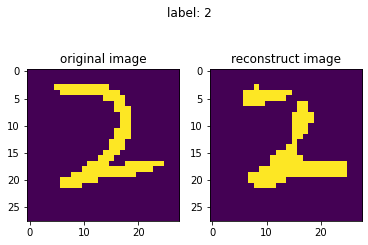

In [78]:
X, y = pretrain_ds[4244]
x_recon = DAE(input_dim=784, latent_dim=2500).apply({'params': state.params}, X.reshape(1, -1))
x_recon = np.argmax(x_recon, axis=-1).reshape(28, 28)
X = X.reshape(28, 28)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(X)
axes[0].set_title("original image")
axes[1].imshow(x_recon)
axes[1].set_title("reconstruct image")
fig.suptitle('label: {}'.format(y))

Мы видим адекватную генерацию изображений, т.е. нормальное предварительное обучение

### saving model

In [80]:
CKPT_DIR = '/content/drive/MyDrive/Colab_Notebooks/BMM_labs/pretrain_ckpt/'
checkpoints.save_checkpoint(ckpt_dir=CKPT_DIR, target=state, step=0)

'/content/drive/MyDrive/Colab_Notebooks/BMM_labs/pretrain_ckpt/checkpoint_0'

In [8]:
CKPT_DIR = '/content/drive/MyDrive/Colab_Notebooks/BMM_labs/pretrain_ckpt/'
state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=None)

In [9]:
state['params']['encoder']

{'bias': array([ 0.0658314 , -0.16337036,  0.01710749, ...,  0.0075219 ,
        -0.16186292, -0.15282159], dtype=float32),
 'kernel': array([[-0.00739401,  0.00889667,  0.01171623, ..., -0.05159254,
         -0.0037093 , -0.01265596],
        [ 0.0166739 , -0.02896277,  0.06811887, ..., -0.03125235,
          0.01956843,  0.02545662],
        [ 0.03356701,  0.04034981, -0.03528691, ..., -0.01932927,
         -0.00298789,  0.06721595],
        ...,
        [-0.00931738, -0.04421821, -0.07289184, ...,  0.00195538,
          0.01829257, -0.0637685 ],
        [-0.02490483,  0.00026116,  0.05606535, ...,  0.01298762,
         -0.00547122, -0.02149028],
        [ 0.04439409, -0.03812018,  0.00960604, ...,  0.00893904,
          0.01839208, -0.00927226]], dtype=float32)}

## Online fine-tuning

### Create a classifier

In [10]:
class DEClassifier(nn.Module):
    latent_dim : int
    num_classes: int

    def setup(self):
        self.encoder = nn.Dense(features=self.latent_dim)
        self.head = nn.Dense(features=self.num_classes)

    def __call__(self, x):
        mask = np.random.rand(*x.shape) * x
        mask = (0 < mask) * (mask <= 0.1)
        x_noisy = x * mask
        z = self.encoder(x_noisy)
        z = nn.relu(z)
        y = self.head(z)
        return y

### create train state

In [11]:
from flax.core.frozen_dict import freeze

def train_pretrain_state(rng_1, rng_2, latent_dim, num_classes, pretrain_state, tx):
    #init params
    model = DEClassifier(latent_dim=latent_dim, num_classes=num_classes)
    x = jnp.empty(shape=(1, 784))
    variables_pretrain = model.init(rng_1, x)
    variables_scratch = model.init(rng_2, x)
    params_pretrain = variables_pretrain['params']
    params_scratch = variables_scratch['params']
    #transfering params
    params_pretrain = params_pretrain.unfreeze()
    params_pretrain['encoder'] = pretrain_state['params']['encoder']
    params_pretrain = freeze(params_pretrain)
    #create states
    pretrain_state = train_state.TrainState.create(apply_fn=model.apply, 
                                               params=params_pretrain, tx=tx)

    scratch_state = train_state.TrainState.create(apply_fn=model.apply, 
                                                params=params_scratch, tx=tx)
    
    return pretrain_state, scratch_state

### loss objective

In [12]:
def cross_entropy_loss(*, logits, labels):
  labels_onehot = jax.nn.one_hot(labels, num_classes=10)
  return optax.softmax_cross_entropy(logits=logits, labels=labels_onehot).mean()

### test dataset

In [15]:
batch_size=1024
data_path = '/content/drive/MyDrive/Colab_Notebooks/BMM_labs/data.zip'

test_ds = DataMnist(data_path=data_path, ids_slice=[10000000, 10500000])
test_dl = data.DataLoader(test_ds, batch_size=batch_size, collate_fn=numpy_collate, num_workers=0)

### step

In [16]:
def compute_metrics(*, logits, labels):
  loss = cross_entropy_loss(logits=logits, labels=labels)
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  metrics = {
      'loss': loss,
      'accuracy': accuracy,
  }
  return metrics

In [24]:
@jax.jit
def eval_step(params, batch):
    input, labels = batch
    logits = DEClassifier(latent_dim=2500, num_classes=10).apply({'params': params}, input)
    return compute_metrics(logits=logits, labels=labels)

In [18]:
@jax.jit
def train_step(state, batch):
    # with jax.profiler.trace("/tmp/jax-trace", create_perfetto_link=True):
    """Train for a single step."""
    input, labels = batch
    def loss_fn(params):
        logits = DEClassifier(latent_dim=2500, num_classes=10).apply({'params': params}, input)
        loss = cross_entropy_loss(logits=logits, labels=labels)
        return loss, logits
    grad_fn = jax.grad(loss_fn, has_aux=True)
    grads, logits = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    metrics = compute_metrics(logits=logits, labels=labels)
    return state, metrics

### eval model

In [19]:
def eval_model(params, tets_dl):
    batch_metrics = []
    for batch in test_dl:
        metrics = eval_step(params, batch)
        batch_metrics.append(metrics)

    # compute mean of metrics across each batch
    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {
        k: np.mean([metrics[k] for metrics in batch_metrics_np])
        for k in batch_metrics_np[0]} # jnp.mean does not work on lists

    return epoch_metrics_np['loss'], epoch_metrics_np['accuracy']

### train models

In [20]:
def train_epoch(state, epoch, train_dl):
    """Train for a single epoch."""
    batch_metrics = []
    for batch in tqdm(train_dl):
        state, metrics = train_step(state, batch)
        batch_metrics.append(metrics)

    # compute mean of metrics across each batch in epoch.
    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {
        k: np.mean([metrics[k] for metrics in batch_metrics_np])
        for k in batch_metrics_np[0]} # jnp.mean does not work on lists

    print('train epoch: %d, loss: %.4f, accuracy: %.2f' % (
      epoch, epoch_metrics_np['loss'], epoch_metrics_np['accuracy'] * 100))
    return state

In [21]:
def train_model(num_epochs, train_dl, test_ds, state):
    losses = []
    for epoch in range(num_epochs):
        state = train_epoch(state, epoch, train_dl)
        test_loss, test_accuracy = eval_model(state.params, test_ds)
        print('\ntest epoch: %d, loss: %.2f, accuracy: %.2f' % (
            epoch, test_loss, test_accuracy * 100))
        losses.append(test_loss)
    return losses

In [22]:
rng_1 = jax.random.PRNGKey(1)
rng_1, rng_2 = jax.random.split(rng_1)

В ходе эксперимента необходимо провести обучение 2-х моделей на N датасетах c увеличивающимся размером. В ходе обучения у меня идет расхождение трейн и тест лосса, а также вылет по памяти RAM из-за кэширования, которое не очищается

In [25]:
number_exmaples_seen = jnp.arange(250000, 10000000, 250000)
scratch_online_classification_error = {}
pretrain_online_classification_error = {}
num_epochs=5
batch_size=1024
data_path = '/content/drive/MyDrive/Colab_Notebooks/BMM_labs/data.zip'

for num_examples in number_exmaples_seen:
    print(f"NUM EXAMPLES: {num_examples}")
    pretrain_state, scratch_state = train_pretrain_state(rng_1, rng_2, 2500, 10,
                                                         state, tx=optax.adam(learning_rate=1e-2))
    
    train_ds = DataMnist(data_path=data_path, ids_slice=[0, num_examples])
    train_dl = data.DataLoader(train_ds, batch_size=batch_size, collate_fn=numpy_collate, num_workers=0)

    print("TRAIN SCRATCH MODEL:\n")
    scratch_online_classification_error[num_examples] = train_model(num_epochs, train_dl, test_ds, scratch_state)
    if num_examples > 2500000:
        print("FINE-TUNE PRETRAIN MODEL:\n")
        pretrain_online_classification_error[num_examples] = train_model(num_epochs, train_dl, test_ds, pretrain_state)

NUM EXAMPLES: 250000
TRAIN SCRATCH MODEL:



100%|██████████| 245/245 [00:02<00:00, 120.63it/s]


train epoch: 0, loss: 1.0947, accuracy: 63.02

test epoch: 0, loss: 1.10, accuracy: 63.23


100%|██████████| 245/245 [00:01<00:00, 233.45it/s]


train epoch: 1, loss: 0.8017, accuracy: 72.96

test epoch: 1, loss: 1.20, accuracy: 62.23


100%|██████████| 245/245 [00:01<00:00, 226.48it/s]


train epoch: 2, loss: 0.6060, accuracy: 79.57

test epoch: 2, loss: 1.41, accuracy: 60.66


100%|██████████| 245/245 [00:01<00:00, 235.18it/s]


train epoch: 3, loss: 0.4571, accuracy: 84.51

test epoch: 3, loss: 1.66, accuracy: 58.81


100%|██████████| 245/245 [00:01<00:00, 182.42it/s]


train epoch: 4, loss: 0.3564, accuracy: 87.84

test epoch: 4, loss: 1.95, accuracy: 58.98


TypeError: ignored